In [195]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

import dpkt
import numpy as np
import time
import brewer2mpl
import AttackAnalysis

reload(AttackAnalysis)
from AttackAnalysis import compute_effective_rate, compute_sending_rate, compute_all_rates
from analyze import compute_global_throughput, parse_file, removeOutliers
from read_conf import ReadHosts

In [159]:
host_to_ip, ip_to_host = ReadHosts('../experiment_conf/experiment_oak.conf')
interval = 5
root_dir = 'workdir/results-exp4-new/'
figures_dir = 'paper-plots/exp4_nash_new/'

# postfixes to go through
postfixes=[]
titles=[]
for k in [1,2,3,4]:
    for d in [12,15,16,17,18,20]:
        app = str(k) + '_d_' + str(d)
        title = '(k=%d, m=%d)' %(k,d)
        postfixes.append(app)
        titles.append(title)

postfixes = np.array(postfixes)

In [160]:
linestyles = ['-', '--', '-.', ':']
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != ' ':
            markers.append(m)
    except TypeError:
        pass

styles = markers + [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

In [161]:
def get_througput_array (entry, interval_s):
    num_buckets = np.size(entry.inbytes)
    buckets = np.arange(0, num_buckets * interval_s, interval_s)

    bps = 10e-6 * entry.inbytes * 8 / interval_s
    
    return buckets, bps

In [162]:
def compute_everything(prefix='results-experiment_4_rerun_k_', capfile='servernode-log_agent-tcpdump.cap',
                       verbose=False, postfix=[''], shost='servernode'):
    throughput = {}
    for post in postfix:
        if (post == '1_d_12' or post == '1_d_20' or post == '2_d_12' or post == '2_d_20' 
            or post == '3_d_12' or post == '3_d_20' or post == '4_d_12' or post == '4_d_20'):
            filename = 'workdir/results-experiment4/'+ 'results-experiment4_k_' + post
        else:
            filename = root_dir + prefix + post
        print "----> Generating throughput for %s" % filename
        filename += '/' + capfile

        start_time = time.time()
        throughput[post] = compute_global_throughput(filename, interval, host_to_ip[shost])
        end_time = time.time()
        if verbose:
            print "Time taken is ", end_time - start_time
            
    return throughput

In [163]:
def plot_next_to_each_other(in_throughput, in_host_to_ip, titles, postfix, host='clientnode-1',
                            yincr=5, ylimincr=5, ystart=-1, coloridx=1, variance=False):
    fig = plt.figure()
    plotnum = 1
    
    num_subplots = len(postfix)
    if num_subplots == 0:
        print "[ERROR:] Empty input postfix array!"
        return 
    
    host_ip = in_host_to_ip[host]
    
    # put three plots next to each other
    num_rows = num_subplots / 4
    if num_subplots % 4 > 0:
        num_rows += 1
    
    k = 0
    for post in postfix:
        maxbps = 0
    
        ax = fig.add_subplot(num_rows,4,plotnum)
        th = in_throughput[post]
        host_th = th[host_ip]

        host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)

        ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', 
                label=post, linewidth=2, color=colors[coloridx])
        plotnum += 1
            
        maxbps = np.maximum(maxbps, np.max(host_bps))

        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(ystart, maxbps+ylimincr)
        ax.set_xticks([0,100,200,300,400,500,600])
        ax.set_xlim(0,599)

        # set y ticks
        yrange = np.arange (0,maxbps+ylimincr,yincr)
        ax.set_yticks(yrange)

#         if k%3==0:
#             ax.set_yticklabels([])  
        if k%3==0:
            ax.set_ylabel('Throughput (Mbps)')
        
        ax.set_xlabel('Time (seconds)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        ax.set_axisbelow(True)
        ax.set_title(titles[k])
        
        # draw the average line
        mean = np.mean(host_bps[24:96])
        # ax.axhline(np.mean(host_bps[24:96]), linestyle='--', linewidth=2, xmin=.2, xmax=.8)
        ax.axhline(np.mean(host_bps[24:96]), linestyle='--', linewidth=2)
        if variance:
            cvar = np.std(host_bps[24:96])
            ax.axhline(mean+cvar, linestyle='--', linewidth=1, color=colors[2])
            ax.axhline(mean-cvar, linestyle='--', linewidth=1, color=colors[2])

        ax.axvspan(120,480,color='red', alpha=0.1)
        k += 1
        

#     if num_subplots%3 == 0:
#         ax = fig.axes[-3]
#     elif num_subplots%3 == 2:
#         ax = fig.axes[-2]
#     elif num_subplots%3 == 1:
#         ax = fig.axes[-1]
    
#     legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.2), borderaxespad=1.0)
#     frame = legend.get_frame()
#     frame.set_facecolor('1')
#     frame.set_edgecolor('0.75')

# Client throughput analysis

In [164]:
throughput = compute_everything(verbose=True, postfix=postfixes)

----> Generating throughput for workdir/results-experiment4/results-experiment4_k_1_d_12
Time to read pcap file 0.000953912734985
Time taken is  185.729835987
----> Generating throughput for workdir/results-exp4-new/results-experiment_4_rerun_k_1_d_15
Time to read pcap file 0.0385370254517
Time taken is  79.7546019554
----> Generating throughput for workdir/results-exp4-new/results-experiment_4_rerun_k_1_d_16
Time to read pcap file 0.0305171012878
Time taken is  62.9258849621
----> Generating throughput for workdir/results-exp4-new/results-experiment_4_rerun_k_1_d_17
Time to read pcap file 0.0234289169312
Time taken is  66.9680669308
----> Generating throughput for workdir/results-exp4-new/results-experiment_4_rerun_k_1_d_18
Time to read pcap file 0.0203588008881
Time taken is  56.4519100189
----> Generating throughput for workdir/results-experiment4/results-experiment4_k_1_d_20
Time to read pcap file 0.000710964202881
Time taken is  52.3192808628
----> Generating throughput for workdi

In [165]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 4)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 10,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [12,21]
   }
plt.rcParams.update(params)

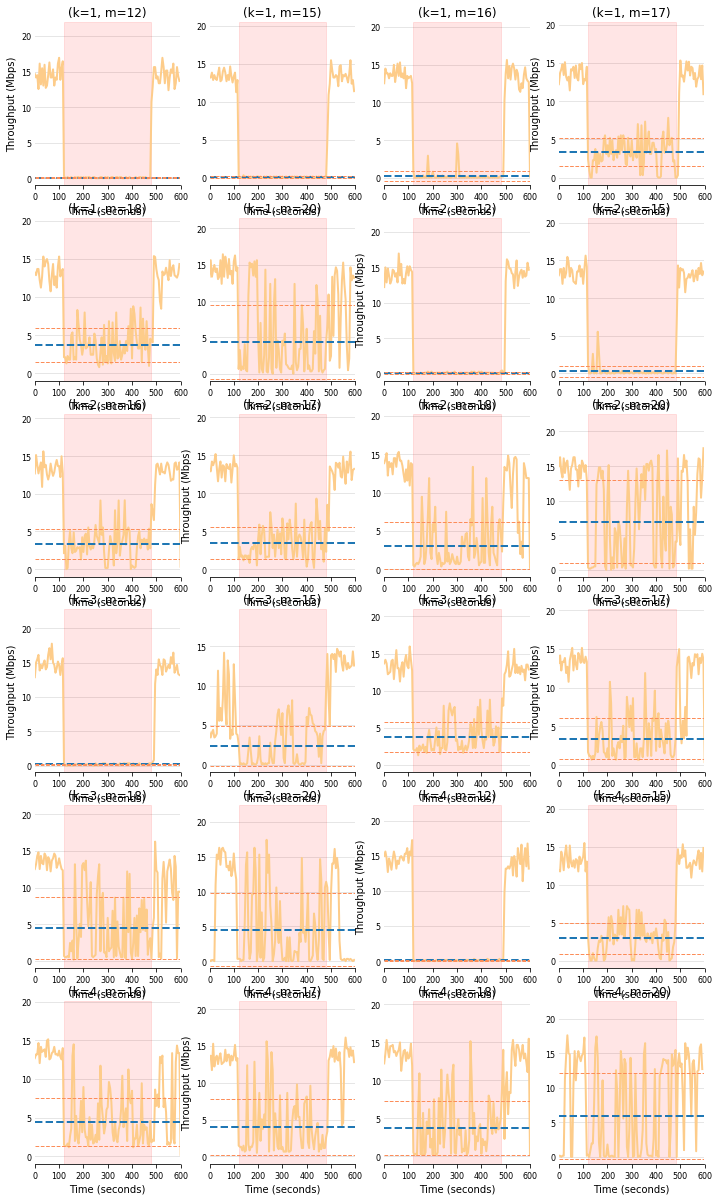

In [166]:
plot_next_to_each_other(throughput, host_to_ip, titles, postfix=postfixes, host='clientnode-9',
                            yincr=5, ylimincr=5, ystart=-1, coloridx=1, variance=True)

In [182]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 6)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 12,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [15,3]
   }
plt.rcParams.update(params)

In [183]:
# fix up the data into a matrix
def prepare_data_for_plot(in_throughput, in_host_to_ip=host_to_ip, host='clientnode-1'):
    # throughput is of the form [key] = throughput for all clients
    data = {}
    host_ip = in_host_to_ip[host]
    for k in [1,2,3,4]:
        data[k] = []
        for m in [12,15,16,17,18,20]: 
            key = str(k) + '_d_' + str(m)
            host_bucket, host_bps = get_througput_array (in_throughput[key][host_ip], interval_s=interval)
            data[k].append(host_bps[24:96])
    
    return data

In [184]:
# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color=colors[0])
    plt.setp(bp['caps'][0], color=colors[0])
    plt.setp(bp['caps'][1], color=colors[0])
    plt.setp(bp['whiskers'][0], color=colors[0])
    plt.setp(bp['whiskers'][1], color=colors[0])
    plt.setp(bp['fliers'][0], color=colors[0])
    plt.setp(bp['fliers'][1], color=colors[0])
    plt.setp(bp['medians'][0], color=colors[0])

    plt.setp(bp['boxes'][1], color=colors[1])
    plt.setp(bp['caps'][2], color=colors[1])
    plt.setp(bp['caps'][3], color=colors[1])
    plt.setp(bp['whiskers'][2], color=colors[1])
    plt.setp(bp['whiskers'][3], color=colors[1])
    plt.setp(bp['fliers'][2], color=colors[1])
    plt.setp(bp['fliers'][3], color=colors[1])
    plt.setp(bp['medians'][1], color=colors[1])
    
    plt.setp(bp['boxes'][2], color=colors[2])
    plt.setp(bp['caps'][4], color=colors[2])
    plt.setp(bp['caps'][5], color=colors[2])
    plt.setp(bp['whiskers'][4], color=colors[2])
    plt.setp(bp['whiskers'][5], color=colors[2])
    plt.setp(bp['fliers'][4], color=colors[2])
    plt.setp(bp['fliers'][5], color=colors[2])
    plt.setp(bp['medians'][2], color=colors[2])

    plt.setp(bp['boxes'][3], color=colors[3])
    plt.setp(bp['caps'][6], color=colors[3])
    plt.setp(bp['caps'][7], color=colors[3])
    plt.setp(bp['whiskers'][6], color=colors[3])
    plt.setp(bp['whiskers'][7], color=colors[3])
    plt.setp(bp['fliers'][6], color=colors[3])
    plt.setp(bp['fliers'][7], color=colors[3])
    plt.setp(bp['medians'][3], color=colors[3])

In [192]:
from matplotlib.patches import Polygon

def handle_axis(bp, ax, k):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if k==1:
        ax.spines['left'].set_visible(False)
        ax.set_ylabel('Throughput(Mbps)')
    else:
        ax.spines['left'].set_linewidth(0.2)
    
    ax.get_xaxis().tick_bottom()
    ax.tick_params(axis='x', direction='out')
    ax.tick_params(axis='y', length=0)
    
    ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    
    for i in range(0, len(bp['boxes'])):
        clr = colors[i]
        bp['boxes'][i].set_color(clr)
        # we have two whiskers
        bp['whiskers'][i*2].set_color(clr)
        bp['whiskers'][i*2 + 1].set_color(clr)
        bp['whiskers'][i*2].set_linewidth(2)
        bp['whiskers'][i*2 + 1].set_linewidth(2)

        bp['medians'][i].set_color('black')
        bp['medians'][i].set_linewidth(3)
        # and 4 caps to remove
        for c in bp['caps']:
            c.set_linewidth(0)

    for i in range(len(bp['boxes'])):
        box = bp['boxes'][i]
        box.set_linewidth(0)
        boxX = []
        boxY = []
        clr = colors[i]
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
            boxCoords = zip(boxX,boxY)
            boxPolygon = Polygon(boxCoords, facecolor = clr, linewidth=0)
            ax.add_patch(boxPolygon)


def plot_box_plots(data, host_to_ip):
    fig = plt.figure()
    
    fig, axes = plt.subplots(ncols=4, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    k=1
    for ax, name in zip(axes, ['k=1','k=2','k=3', 'k=4']):
        bp = ax.boxplot(data[k], showfliers=False)
        ax.set(xticklabels=['m=12', 'm=15', 'm=16', 'm=17', 'm=18','m=20'], xlabel=name)
        ax.margins(0.05) # Optional
        handle_axis(bp, ax, k)
        
        if k == 2:
            ax.axvspan(3.5,4.5, color='green', alpha=0.1)
        
        #if k > 2:
        #    ax.set_yticks([])
        if k==1:
            ax.get_yaxis().tick_left()
        k += 1
    
    plt.savefig(figures_dir + 'nash_box.pdf', bbox_inches = 'tight')

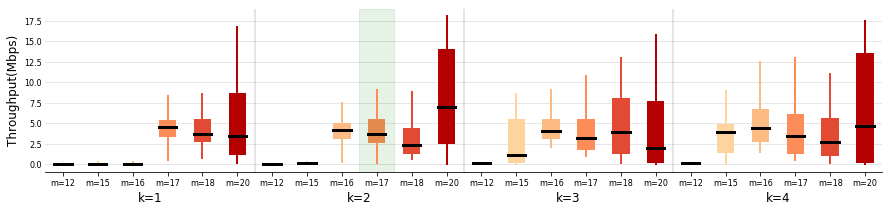

In [194]:
data = prepare_data_for_plot(throughput, host='clientnode-3')
plot_box_plots(data, host_to_ip)

# Attack Analysis

In [ ]:
attacker_list = ['attacknode-1', 'attacknode-2', 'attacknode-3', 'attacknode-4', 'attacknode-5',
                'attacknode-6', 'attacknode-7', 'attacknode-8', 'attacknode-9', 'attacknode-10']
attacker_set = set()
for attacker in attacker_list:
    attacker_set.add (host_to_ip[attacker])

In [119]:
sending_rates = {}

prefix='results-experiment_4_rerun_k_'
for post in postfixes:
    sending_rates[post] = {}
    for attacker in attacker_list:
        attack_file_template = attacker + '-attack_log-tcpdump.cap'
        
        if (post == '1_d_12' or post == '1_d_20' or post == '2_d_12' or post == '2_d_20' 
            or post == '3_d_12' or post == '3_d_20' or post == '4_d_12' or post == '4_d_20'):
            filename = 'workdir/results-experiment4/'+ 'results-experiment4_k_' + post
        else:
            filename = root_dir + prefix + post
        attacker_ip = host_to_ip[attacker]
        
        cap_file = filename + '/' + attack_file_template
        print "-----> Using cap file: %s" % cap_file
        
        effective_rate = compute_sending_rate(cap_file, interval, attacker_ip, 0)    
        sending_rates[post][attacker_ip] = effective_rate

-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-1-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-2-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-3-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-4-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-5-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-6-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-7-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-8-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment4/results-experiment4_k

-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_15/attacknode-1-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_15/attacknode-2-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_15/attacknode-3-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_15/attacknode-4-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_15/attacknode-5-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_15/attacknode-6-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_15/attacknode-7-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_15/attacknode-8-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-e

-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_15/attacknode-10-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_16/attacknode-1-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_16/attacknode-2-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_16/attacknode-3-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_16/attacknode-4-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_16/attacknode-5-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_16/attacknode-6-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_16/attacknode-7-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-

-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_16/attacknode-9-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_16/attacknode-10-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_17/attacknode-1-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_17/attacknode-2-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_17/attacknode-3-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_17/attacknode-4-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_17/attacknode-5-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_17/attacknode-6-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-

In [196]:
attack_rates = {}


prefix='results-experiment_4_rerun_k_'
for post in postfixes:
    attack_rates[post] = {}
    for attacker in attacker_list:
        attack_file_template = attacker + '-attack_log-tcpdump.cap'
        
        if (post == '1_d_12' or post == '1_d_20' or post == '2_d_12' or post == '2_d_20' 
            or post == '3_d_12' or post == '3_d_20' or post == '4_d_12' or post == '4_d_20'):
            filename = 'workdir/results-experiment4/'+ 'results-experiment4_k_' + post
        else:
            filename = root_dir + prefix + post
        attacker_ip = host_to_ip[attacker]
        
        cap_file = filename + '/' + attack_file_template
        print "-----> Using cap file: %s" % cap_file
        
        effective_rate = compute_effective_rate(cap_file, interval, False)    
        entry = effective_rate[attacker_ip]
        attack_rates[post][attacker_ip] = entry

-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-1-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.3 at ts 1511380377.420051. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	161323
Total number of acked connections:     	586
Total number of failed connections:    	113846
Total number of replies received:      	71875
Average ACK rate:                      	1.52207792208
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_12/attacknode-2-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.7.7
Total number of attempted connections: 	1
Total number of acked connections:     	0
Total number of failed connections:    	1
Total number of replies received:      	1
Average ACK rate:                      	0.0
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.7.6
Total number of attempted connections: 	104377
Total number of acked connections:     	1332
Total number of failed connections:    	98115
Total number of replies received:      	99435
Average ACK rate:                      	3.64931506849
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.7.4
Total number of attempted connections: 	21
Total number of acked connections:     	19
Total number of failed connections:    	2
Total numbe

+----------------------------------------------------+
Statistics for host 10.1.7.7
Total number of attempted connections: 	8
Total number of acked connections:     	0
Total number of failed connections:    	8
Total number of replies received:      	0
Average ACK rate:                      	0.0
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.7.5
Total number of attempted connections: 	8
Total number of acked connections:     	0
Total number of failed connections:    	8
Total number of replies received:      	0
Average ACK rate:                      	0.0
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.7.4
Total number of attempted connections: 	40442
Total number of acked connections:     	1195
Total number of failed connections:    	35064
Total number of replies received:      	21065
Average ACK rate:              

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.7
Total number of attempted connections: 	42157
Total number of acked connections:     	150
Total number of failed connections:    	39382
Total number of replies received:      	19549
Average ACK rate:                      	0.41095890411
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_1_d_16/attacknode-6-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.3 at ts 1511744626.499823. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.7.3
Total number of attempted connections: 	48007
Total number of acked connections:     	105
Total number of failed connections:    

[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.3 at ts 1511745305.779503. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.7.3
Total number of attempted connections: 	26614
Total number of acked connections:     	132
Total number of failed connections:    	24854
Total number of replies received:      	14153
Average ACK rate:                      	0.33417721519
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_1_d_17/attacknode-7-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.4 at ts 1511745246.160730. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics fo

[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.7 at ts 1511745969.143510. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.7
Total number of attempted connections: 	11525
Total number of acked connections:     	55
Total number of failed connections:    	11465
Total number of replies received:      	3715
Average ACK rate:                      	0.142857142857
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_1_d_18/attacknode-6-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.3 at ts 1511746038.825747. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+-------------------

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.7.4
Total number of attempted connections: 	12381
Total number of acked connections:     	149
Total number of failed connections:    	11135
Total number of replies received:      	1741
Average ACK rate:                      	0.266071428571
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_1_d_20/attacknode-8-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.5 at ts 1511382575.892339. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.7.5
Total number of attempted connections: 	9570
Total number of acked connections:     	1
Total number of failed connections:    	9213
Total number of replies received:      	1320
Avera

+----------------------------------------------------+
Statistics for host 10.1.7.7
Total number of attempted connections: 	2
Total number of acked connections:     	1
Total number of failed connections:    	1
Total number of replies received:      	0
Average ACK rate:                      	0.2
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.7.3
Total number of attempted connections: 	203910
Total number of acked connections:     	3320
Total number of failed connections:    	119730
Total number of replies received:      	92922
Average ACK rate:                      	8.3
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_2_d_12/attacknode-7-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.4 at ts 1511384728.159239. This should on

[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.5 at ts 1511746569.930725. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.5
Total number of attempted connections: 	47414
Total number of acked connections:     	111
Total number of failed connections:    	43683
Total number of replies received:      	19988
Average ACK rate:                      	0.288311688312
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_15/attacknode-4-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.6 at ts 1511746560.408287. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+-----------------

[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.4 at ts 1511747362.037248. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	11088
Total number of acked connections:     	71
Total number of failed connections:    	11000
Total number of replies received:      	5954
Average ACK rate:                      	0.205797101449
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_16/attacknode-3-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.5 at ts 1511747537.292243. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+-------------------

[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.5 at ts 1511747274.726935. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.7.5
Total number of attempted connections: 	19221
Total number of acked connections:     	389
Total number of failed connections:    	17478
Total number of replies received:      	7444
Average ACK rate:                      	0.984810126582
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_16/attacknode-9-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.6 at ts 1511747211.667622. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+------------------

[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.3 at ts 1511747910.376534. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	9321
Total number of acked connections:     	55
Total number of failed connections:    	9121
Total number of replies received:      	3267
Average ACK rate:                      	0.166666666667
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_17/attacknode-2-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.4 at ts 1511748032.898256. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+---------------------

[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.3 at ts 1511748775.367980. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	4423
Total number of acked connections:     	72
Total number of failed connections:    	4351
Total number of replies received:      	3027
Average ACK rate:                      	0.211764705882
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_2_d_18/attacknode-2-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.4 at ts 1511748643.908252. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+---------------------

[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.6 at ts 1511387040.055307. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.4.6
Total number of attempted connections: 	6669
Total number of acked connections:     	19
Total number of failed connections:    	6438
Total number of replies received:      	937
Average ACK rate:                      	3.8
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_2_d_20/attacknode-5-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.7 at ts 1511387030.331937. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.4.7
Total number of attempted connections: 	3142
Total n

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.6
Total number of attempted connections: 	99942
Total number of acked connections:     	168
Total number of failed connections:    	87427
Total number of replies received:      	45437
Average ACK rate:                      	0.448
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.4.7
Total number of attempted connections: 	2
Total number of acked connections:     	1
Total number of failed connections:    	1
Total number of replies received:      	0
Average ACK rate:                      	0.2
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_3_d_12/attacknode-5-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.7 at ts 1511389014.171299. This should onl

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.5
Total number of attempted connections: 	26715
Total number of acked connections:     	121
Total number of failed connections:    	24472
Total number of replies received:      	7023
Average ACK rate:                      	0.314285714286
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_15/attacknode-4-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.6 at ts 1511749287.886860. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.6
Total number of attempted connections: 	43137
Total number of acked connections:     	105
Total number of failed connections:    

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	10733
Total number of acked connections:     	47
Total number of failed connections:    	10641
Total number of replies received:      	4343
Average ACK rate:                      	0.127027027027
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_16/attacknode-2-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.4 at ts 1511749881.971404. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	13083
Total number of acked connections:     	99
Total number of failed connections:    	1

[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.5 at ts 1511750660.821238. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.5
Total number of attempted connections: 	11854
Total number of acked connections:     	150
Total number of failed connections:    	10806
Total number of replies received:      	3042
Average ACK rate:                      	0.394736842105
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_17/attacknode-4-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.6 at ts 1511750631.823576. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics fo

+----------------------------------------------------+
Statistics for host 10.1.4.6
Total number of attempted connections: 	8504
Total number of acked connections:     	89
Total number of failed connections:    	8113
Total number of replies received:      	2025
Average ACK rate:                      	0.240540540541
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_3_d_18/attacknode-5-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.7 at ts 1511751326.002657. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.7
Total number of attempted connections: 	8344
Total number of acked connections:     	70
Total number of failed connections:    	8244
Total number of replies received:      	1158
Ave

[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.3 at ts 1511391542.663972. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.7.3
Total number of attempted connections: 	3102
Total number of acked connections:     	89
Total number of failed connections:    	2670
Total number of replies received:      	861
Average ACK rate:                      	0.231168831169
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_3_d_20/attacknode-7-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.4 at ts 1511391414.740443. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 1

[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.4 at ts 1511393670.509103. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	95715
Total number of acked connections:     	1855
Total number of failed connections:    	76630
Total number of replies received:      	49455
Average ACK rate:                      	4.6375
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_4_d_12/attacknode-3-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.5 at ts 1511393633.355134. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------

[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.5 at ts 1511393348.662332. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.7.7
Total number of attempted connections: 	3
Total number of acked connections:     	2
Total number of failed connections:    	1
Total number of replies received:      	1
Average ACK rate:                      	0.4
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.7.6
Total number of attempted connections: 	3
Total number of acked connections:     	2
Total number of failed connections:    	1
Total number of replies received:      	1
Average ACK rate:                      	0.4
+----------------------------------------------------+
+----------------------------------------------------+


[WARNING:] Packet for (10.1.7.4,37585) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,40628) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,39949) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,44113) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,44369) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,34789) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,44045) does not have a record for expected sequence number. This indicates that the SYN packet was

[WARNING:] Packet for (10.1.7.4,43059) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,37851) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,46063) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,38045) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.4,46259) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
+----------------------------------------------------+
Statistics for host 10.1.7.7
Total number of attempted connections: 	2
Total number of acked connections:     	1
Total number of failed connections:    	1
Total number of replies received:      	0
Average ACK rate:      

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.7.5
Total number of attempted connections: 	24654
Total number of acked connections:     	457
Total number of failed connections:    	21485
Total number of replies received:      	6744
Average ACK rate:                      	1.34411764706
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_15/attacknode-9-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.6 at ts 1511751982.535130. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.7.6
Total number of attempted connections: 	19186
Total number of acked connections:     	539
Total number of failed connections:    	

+----------------------------------------------------+
Statistics for host 10.1.7.6
Total number of attempted connections: 	14381
Total number of acked connections:     	343
Total number of failed connections:    	12440
Total number of replies received:      	4893
Average ACK rate:                      	0.753846153846
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_16/attacknode-10-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
[WARNING:] Received RST packet for a non tracked connection at host 10.1.7.7 at ts 1511752741.970033. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.7.7
Total number of attempted connections: 	13031
Total number of acked connections:     	248
Total number of failed connections:    	11420
Total number of replies received:      	7

[WARNING:] Packet for (10.1.7.7,42737) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
+----------------------------------------------------+
Statistics for host 10.1.7.7
Total number of attempted connections: 	6686
Total number of acked connections:     	140
Total number of failed connections:    	5788
Total number of replies received:      	1015
Average ACK rate:                      	0.363636363636
+----------------------------------------------------+
-----> Using cap file: workdir/results-exp4-new/results-experiment_4_rerun_k_4_d_18/attacknode-1-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.3 at ts 1511754251.720092. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connectio

+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	5161
Total number of acked connections:     	46
Total number of failed connections:    	4916
Total number of replies received:      	719
Average ACK rate:                      	0.0779661016949
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment4/results-experiment4_k_4_d_20/attacknode-3-attack_log-tcpdump.cap
[WARNING:] Received RST packet for a non tracked connection at host 10.1.4.5 at ts 1511396069.867914. This should only happen for benign clients.
[WARNING:] Will display this warning only once.
+----------------------------------------------------+
Statistics for host 10.1.4.5
Total number of attempted connections: 	487
Total number of acked connections:     	136
Total number of failed connections:    	351
Total number of replies received:      	478
Average ACK rate:                      	1.81333333333
+---

[WARNING:] Packet for (10.1.7.7,41199) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.7,34123) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.7,34309) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.7,40083) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.7,45811) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.7,41865) does not have a record for expected sequence number. This indicates that the SYN packet was not yet sent.
[WARNING:] Packet for (10.1.7.7,33573) does not have a record for expected sequence number. This indicates that the SYN packet was

+----------------------------------------------------+
Statistics for host 10.1.7.7
Total number of attempted connections: 	6211
Total number of acked connections:     	210
Total number of failed connections:    	4899
Total number of replies received:      	940
Average ACK rate:                      	0.306569343066
+----------------------------------------------------+


In [120]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('Set2', 'qualitative', 4)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 9,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [9, 14]
   }
plt.rcParams.update(params)

In [199]:
#numerical_rates = [50,100,200,300,400,500,600,700,800,900,1000]

full_rates = {}
full_ack_rates = {}
for post in postfixes:
    flatten_rates = None
    ack_rates = None
    for attacker in attacker_set:
        local_rate = sending_rates[post][attacker]
        if (flatten_rates is None):
            flatten_rates = local_rate
        else:
            flen = len(flatten_rates)
            rlen = len(local_rate)
            
            padded_rate = local_rate
            if flen > rlen:
                padded_rate = np.pad(local_rate, (0, flen-rlen), 'constant')
            elif rlen > flen:
                flatten_rates =  np.pad(flatten_rates, (0, rlen-flen), 'constant')
            assert (len(flatten_rates) == len(padded_rate))
            flatten_rates = flatten_rates + padded_rate
        
        local_ack_rate = attack_rates[post][attacker]
        if (ack_rates is None):
            ack_rates = local_ack_rate
        else:
            flen = len(ack_rates)
            rlen = len(local_ack_rate)
            
            padded_ack_rate = local_ack_rate
            if flen > rlen:
                padded_ack_rate = np.pad(local_ack_rate, (0, flen-rlen), 'constant')
            elif rlen > flen:
                ack_rates = np.pad(ack_rates, (0,rlen-flen), 'constant')
            assert(len(ack_rates) == len(padded_ack_rate))
            ack_rates = ack_rates + padded_ack_rate
            
    full_rates[post] = flatten_rates
    full_ack_rates[post] = ack_rates

# get the stuff for the sending rates
avg_rates = np.array([0]*len(postfixes))
err_bars = np.array([0]*len(postfixes))
i=0
for post in postfixes:
    avg_rates[i] = np.mean(full_rates[post])
    err_bars[i] = stats.sem(full_rates[post])
    i += 1

# now do the same for the ack rates
avg_ack_rates = np.array([0]*len(postfixes))
err_ack_bars = np.array([0]*len(postfixes))
i=0
for post in postfixes:
    avg_ack_rates[i] = np.mean(full_ack_rates[post])
    err_ack_bars[i] = stats.sem(full_ack_rates[post])
    i += 1
    
print titles[2], titles[3], titles[8], titles[9]
print avg_rates[2], avg_rates[3], avg_rates[8], avg_rates[9]
print avg_ack_rates[2], avg_ack_rates[3], avg_ack_rates[8], avg_ack_rates[9]

(k=1, m=16) (k=1, m=17) (k=2, m=16) (k=2, m=17)
5165 2719 2250 1668
59 34 30 22


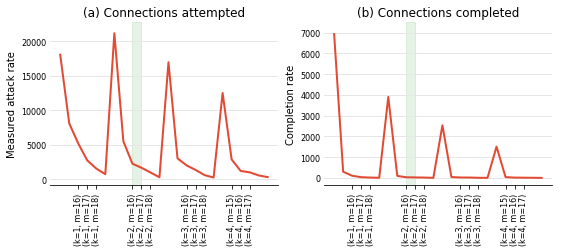

In [176]:
xaxis = np.arange(0, len(postfixes))
display_axis = np.array([2,3,4,8,9,10,14,15,16,19,20,21])
display_titles = []
for i in display_axis:
    display_titles.append(titles[i])

# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 3)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 10,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [9,3]
   }
plt.rcParams.update(params)

figpath = figures_dir + 'combined.pdf'

fig = plt.figure()
# now plot the stuff
ax = fig.add_subplot(1,2,1)
ax.plot(xaxis,  avg_rates, linewidth=2, color=colors[-1])

high=[]
low=[]
for val, err in zip(avg_rates, err_bars):
    high.append(val+err)
    low.append(val-err)

ax.fill_between(xaxis, high, low, alpha=0.15, linewidth=0, color=colors[-1])


#ax.set_xlabel('Attack rate per node (pps)')
#ax.set_xticks(titles)
ax.set_xticks(display_axis)
ax.set_xticklabels(display_titles, rotation='vertical')
ax.set_ylabel('Measured attack rate')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
#ax.set_xlim(50,1050)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', length=0)
ax.set_title('(a) Connections attempted')
ax.axvspan(8,9, color='green', alpha=0.1)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(xaxis, avg_ack_rates, linewidth=2, color=colors[-1])
high=[]
low=[]
for val, err in zip(avg_ack_rates, err_ack_bars):
    high.append(val+err)
    low.append(val-err)

ax2.fill_between(xaxis, high, low, alpha=0.15, linewidth=0, color=colors[-1])


ax2.set_ylabel('Completion rate')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
#ax2.set_xlim(50,1050)
#ax2.set_ylim(-1,15)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()
ax2.tick_params(axis='x', direction='out')
ax2.tick_params(axis='y', length=0)
ax2.set_xticks(display_axis)
ax2.set_xticklabels(display_titles, rotation='vertical')
ax2.set_title('(b) Connections completed')
ax2.axvspan(8,9, color='green', alpha=0.1)